# Download readme file

In [1]:
!pip install --upgrade gdown
!gdown '1IlFFEjwH4e7RpEUzfYEA35xJQwOasjWw'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Downloading...
From: https://drive.google.com/uc?id=1IlFFEjwH4e7RpEUzfYEA35xJQwOasjWw
To: /content/readme.md
100% 876/876 [00:00<00:00, 1.89MB/s]


#Required imports and definitions

In [2]:
def check_dependencies_already_installed() -> bool:
    try:
        import gdown
        import tensorflow_addons
        return True
    except ImportError:
        return False


def install_dependencies():
    !pip install 'tensorflow_addons' 'tensorflow-determinism'
    !pip install --upgrade gdown


dependencies_already_installed = check_dependencies_already_installed()
print(f'dependencies_already_installed: {dependencies_already_installed}')
if not dependencies_already_installed:
    install_dependencies()


import os
import random
import json
from enum import Enum
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import vgg19  # For the Neural Style Transfer
from tensorflow.python.data.ops.dataset_ops import Dataset
from tensorflow.python.distribute.tpu_strategy import TPUStrategy
from skimage.metrics import structural_similarity
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image
from pathlib import Path
from datetime import datetime
from zipfile import ZipFile
from google.colab import files

dependencies_already_installed: True


# Architecture 1 - Cycle GAN

## Model code

In [3]:
class GeneratorNetworkStructure(Enum):
    Baseline = 'baseline'
    Thin = 'thin'
    Wide = 'wide'
    Deep = 'deep'


class DiscriminatorNetworkStructure(Enum):
    Baseline = 'baseline'
    ThinNetwork = 'thin_network'
    WideNetwork = 'wide_network'
    ThinReceptiveField = 'thin_receptive_field'
    WideReceptiveField = 'wide_receptive_field'


def _down_sample_layer(filters, size, strides=2, padding='same'):
    initializer = tf.random_normal_initializer(0., 0.02)

    network = keras.Sequential()
    network.add(layers.Conv2D(filters, size, strides=strides, padding=padding,
                              kernel_initializer=initializer, use_bias=False))

    network.add(layers.LeakyReLU())

    return network


def _up_sample_layer(filters, size, strides=2, padding='same', apply_dropout=False):
    network = keras.Sequential()
    network.add(layers.Conv2DTranspose(
        filters, size, strides=strides, padding=padding, use_bias=False,
        kernel_initializer=tf.random_normal_initializer(0., 0.02)
    ))
    if apply_dropout:
        network.add(layers.Dropout(0.5))
    network.add(layers.ReLU())
    return network

def build_generator_model(generator_network_structure: GeneratorNetworkStructure):
    down_stack, up_stack = _build_generator_encoder_decoder_layout(generator_network_structure)
    inputs = layers.Input(shape=[320, 320, 3])

    layers_to_direct_to_previous = []
    x = inputs
    for down in down_stack:
        x = down(x)
        layers_to_direct_to_previous.append(x)

    for up, skip in zip(up_stack, reversed(layers_to_direct_to_previous[:-1])):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    initializer = tf.random_normal_initializer(0.0, 0.02)
    last_layer = layers.Conv2DTranspose(3, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')
    generator_model = keras.Model(inputs=inputs, outputs=last_layer(x))
    return generator_model


def _build_generator_encoder_decoder_layout(network_structure: GeneratorNetworkStructure):
    if network_structure is GeneratorNetworkStructure.Baseline:
        down_stack = [
            _down_sample_layer(64, 4),
            _down_sample_layer(128, 4),
            _down_sample_layer(256, 4),
            _down_sample_layer(512, 4),
            _down_sample_layer(512, 4),
            _down_sample_layer(512, 4),
            _down_sample_layer(512, 4, strides=1, padding='valid'),
            _down_sample_layer(512, 4),
        ]
        up_stack = [
            _up_sample_layer(512, 4, apply_dropout=True),
            _up_sample_layer(512, 4, strides=1, padding='valid', apply_dropout=True),
            _up_sample_layer(512, 4, apply_dropout=True),
            _up_sample_layer(512, 4),
            _up_sample_layer(256, 4),
            _up_sample_layer(128, 4),
            _up_sample_layer(64, 4),
        ]
    elif network_structure is GeneratorNetworkStructure.Thin:
        down_stack = [
            _down_sample_layer(64, 4),
            _down_sample_layer(128, 4),
            _down_sample_layer(128, 4),
            _down_sample_layer(256, 4),
            _down_sample_layer(256, 4),
            _down_sample_layer(256, 4),
            _down_sample_layer(512, 4, strides=1, padding='valid'),
            _down_sample_layer(512, 4),
        ]
        up_stack = [
            _up_sample_layer(512, 4, apply_dropout=True),
            _up_sample_layer(512, 4, strides=1, padding='valid', apply_dropout=True),
            _up_sample_layer(256, 4, apply_dropout=True),
            _up_sample_layer(256, 4),
            _up_sample_layer(128, 4),
            _up_sample_layer(128, 4),
            _up_sample_layer(64, 4),
        ]
    elif network_structure is GeneratorNetworkStructure.Wide:
        down_stack = [
            _down_sample_layer(64, 4),
            _down_sample_layer(256, 4),
            _down_sample_layer(512, 4),
            _down_sample_layer(1_024, 4),
            _down_sample_layer(1_024, 4),
            _down_sample_layer(1_024, 4),
            _down_sample_layer(1_024, 4, strides=1, padding='valid'),
            _down_sample_layer(512, 4),
        ]
        up_stack = [
            _up_sample_layer(1_024, 4, apply_dropout=True),
            _up_sample_layer(1_024, 4, strides=1, padding='valid', apply_dropout=True),
            _up_sample_layer(1_024, 4, apply_dropout=True),
            _up_sample_layer(1_024, 4),
            _up_sample_layer(512, 4),
            _up_sample_layer(256, 4),
            _up_sample_layer(64, 4),
        ]
    elif network_structure is GeneratorNetworkStructure.Deep:
        down_stack = [
            _down_sample_layer(64, 4),
            _down_sample_layer(128, 4),
            _down_sample_layer(128, 4, strides=1, padding='same'),
            _down_sample_layer(256, 4),
            _down_sample_layer(256, 4, strides=1, padding='same'),
            _down_sample_layer(512, 4),
            _down_sample_layer(512, 4, strides=1, padding='same'),
            _down_sample_layer(512, 4),
            _down_sample_layer(512, 4, strides=1, padding='same'),
            _down_sample_layer(512, 4),
            _down_sample_layer(512, 4, strides=1, padding='valid'),
            _down_sample_layer(512, 4),
        ]
        up_stack = [
            _up_sample_layer(512, 4, apply_dropout=True),
            _up_sample_layer(512, 4, strides=1, padding='valid', apply_dropout=True),
            _up_sample_layer(512, 4, apply_dropout=True),
            _up_sample_layer(512, 4, strides=1, padding='same'),
            _up_sample_layer(512, 4),
            _up_sample_layer(512, 4, strides=1, padding='same'),
            _up_sample_layer(256, 4),
            _up_sample_layer(256, 4, strides=1, padding='same'),
            _up_sample_layer(128, 4),
            _up_sample_layer(128, 4, strides=1, padding='same'),
            _up_sample_layer(64, 4),
        ]
    else:
        raise NotImplementedError(f"unknown network structure - '{network_structure}'")
    return down_stack, up_stack


def prepare_image_tensor_for_inference(image):
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [256, 256, 3])
    image = tf.image.resize(image, (320, 320), method='bilinear')
    image = tf.reshape(image, [1, 320, 320, 3])
    return image


def get_user_test_image():
    print("\nplease upload a test image")
    uploaded = files.upload()
    uploaded_file_path = list(uploaded.keys())[0]  
    return uploaded_file_path

## Test flow definitions
please execute the cell below in order to test Archictecture 1

In [4]:
DOWNLOADED_BEST_MODEL_FILES_ZIP_PATH = Path('./experiment_outputs.zip')
EXTRACTED_BEST_MODEL_FILES_FOLDER_PATH = Path('./experiment_outputs/23_02_24__10_25_05/monet_generator.ckpt')


def download_arch1_best_model_files_if_not_present():
    if not DOWNLOADED_BEST_MODEL_FILES_ZIP_PATH.exists():
        print('downloading best model weights')
        !gdown '1ugheNTk1ZRCqS5SBBl56sShG0yUkhaqF'
        !unzip {DOWNLOADED_BEST_MODEL_FILES_ZIP_PATH}
        assert EXTRACTED_BEST_MODEL_FILES_FOLDER_PATH.parent.exists()


def generate_prediction_for_test_image(arch1_best_monet_gen_model, test_image_file_path):
    test_image = Image.open(test_image_file_path)
    test_image_tensor = tf.convert_to_tensor(test_image)
    prepared_test_image_tensor = prepare_image_tensor_for_inference(test_image_tensor)

    prediction = arch1_best_monet_gen_model(prepared_test_image_tensor, training=False)[0]

    # revert model images normalization
    prediction = prediction.numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    predicted_image = Image.fromarray(prediction)
    return predicted_image

def architecture1_styling(image_file_path):
    download_arch1_best_model_files_if_not_present()
    arch1_best_monet_gen_model = build_generator_model(GeneratorNetworkStructure.Thin)
    arch1_best_monet_gen_model.load_weights(str(EXTRACTED_BEST_MODEL_FILES_FOLDER_PATH))
    predicted_image = generate_prediction_for_test_image(arch1_best_monet_gen_model, image_file_path)
    return predicted_image

## Test flow execution


please upload a test image


Saving 00dcf0f1e3.jpg to 00dcf0f1e3 (10).jpg


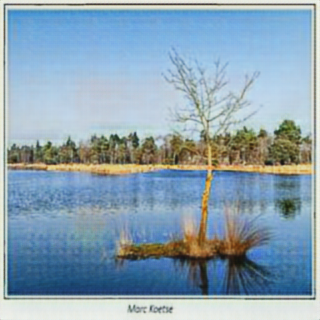

In [5]:
uploaded_file_path = get_user_test_image()
architecture1_styling(uploaded_file_path)

# Architecture 2 - Neural Style Transfer

## Model prerequisites

In [6]:
LOCAL_DATASET_FOLDER_PATH = Path('./train_data/gan-getting-started/')


# This is required for the Neural Style Transfer model (that takes a single monet image)
def download_competition_dataset_if_not_present():
    dataset_already_downloaded = LOCAL_DATASET_FOLDER_PATH.exists()
    print(f"dataset_already_downloaded: {dataset_already_downloaded}")
    if not dataset_already_downloaded:
        # note - this is the untouched competition dataset. just uploaded it to the drive so it'll be
        # available via colab as well.
        !gdown '1ZwcoO11NKhYsbuM7hzdSzKjGOnOx6X94'
        !mkdir -p {LOCAL_DATASET_FOLDER_PATH}
        !unzip -o -q ./gan-getting-started.zip -d {LOCAL_DATASET_FOLDER_PATH}


download_competition_dataset_if_not_present()

dataset_already_downloaded: True


In [7]:
def choose_strongest_available_device_strategy():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        selected_strategy = TPUStrategy(tpu)
    except:
        selected_strategy = tf.distribute.get_strategy()

    print(f"choose_strongest_available_device_strategy() - selected strategy type: {type(selected_strategy).__name__}")

    gpu_is_available = any(tf.config.list_physical_devices('GPU'))
    if gpu_is_available:
        # show gpu info
        !nvidia-smi

    print(f'\n\n*** running_on_tpu - {isinstance(selected_strategy, TPUStrategy)} ***\n\n')
    return selected_strategy



DEVICE_STRATEGY = choose_strongest_available_device_strategy()

choose_strongest_available_device_strategy() - selected strategy type: _DefaultDistributionStrategy
Sun Feb 26 20:19:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    58W / 400W |   9551MiB / 40960MiB |     11%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+------------

In [8]:
def find_competition_dataset_files(local_dataset_folder_path: Path):
    if isinstance(DEVICE_STRATEGY, TPUStrategy):
        from kaggle_datasets import KaggleDatasets
        dataset_folder_path = Path(KaggleDatasets().get_gcs_path())
    else:
        dataset_folder_path = local_dataset_folder_path

    monet_dataset_files = tf.io.gfile.glob(str(dataset_folder_path / 'monet_tfrec/*.tfrec'))
    photo_dataset_files = tf.io.gfile.glob(str(dataset_folder_path / 'photo_tfrec/*.tfrec'))
    assert any(monet_dataset_files)
    assert any(photo_dataset_files)
    print(f"found {len(monet_dataset_files)} monet and {len(photo_dataset_files)} photo tfrec files.")

    return monet_dataset_files, photo_dataset_files


def load_tf_records_raw_dataset(tf_record_files) -> Dataset:
    def _read_and_normalize_tfrecord(record):
        tfrecord_format = {
            "image_name": tf.io.FixedLenFeature([], tf.string),
            "image": tf.io.FixedLenFeature([], tf.string),
            "target": tf.io.FixedLenFeature([], tf.string)
        }
        record = tf.io.parse_single_example(record, tfrecord_format)
        image = record['image']
        image = tf.image.decode_jpeg(image, channels=3)
        return image

    sorted_tf_record_files = sorted(tf_record_files)
    raw_dataset = tf.data.TFRecordDataset(sorted_tf_record_files)
    raw_dataset = raw_dataset.map(_read_and_normalize_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return raw_dataset


def normalize_images_dataset_for_model(images_dataset: Dataset, zero_mean = True, batch_size: int = 1) -> Dataset:
    def _prepare_image_tensor_for_training(image):
        if zero_mean:
            image = (tf.cast(image, tf.float32) / 127.5) - 1
        image = tf.reshape(image, [256, 256, 3])
        image = tf.image.resize(image, (320, 320), method='bilinear')
        return image

    images_dataset = images_dataset.map(
        _prepare_image_tensor_for_training, num_parallel_calls=tf.data.experimental.AUTOTUNE
    ).batch(batch_size)
    return images_dataset

## Model code

In [9]:
# The gram matrix is used in style loss to measure the similarity
# of feature maps in different layers.
def _gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# Style loss is a way to quantify the difference between the style of one
# image (e.g., a painting) and the content of another image (e.g., a photograph)
# in order to transfer the style of the former to the latter.
def style_loss(style, combination):
    S = _gram_matrix(style)
    C = _gram_matrix(combination)
    channels = 3
    size = 320 * 320
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))


# Content loss is a term used to measure how well the content of an input image
# is preserved in the stylized output image.
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# Total variation loss is a regularization term used to promote smoothness
# and reduce noise in the stylized output image.
def total_variation_loss(x):
    img_size = 320
    a = tf.square(
        x[:, : img_size - 1, : img_size - 1, :] - x[:, 1:, : img_size - 1, :]
    )
    b = tf.square(
        x[:, : img_size - 1, : img_size - 1, :] - x[:, : img_size - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))


# Build a VGG19 model loaded with pre-trained ImageNet weights.
# Originally this model support images size 224x224.
# vgg19.preprocess_input util-method is responsible for image size conversion.
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer.
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in VGG19.
feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=outputs_dict)


# Preprocess the input image before it is fed into the VGG19 model.
def preprocess_image(img):
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


# Deprocess the VGG19 tensor into an image
def deprocess_image(x):
    x = x.reshape((320, 320, 3))
    # Each color channel is zero-centered with respect to the ImageNet dataset
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x


    
# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image,
                 base_image,
                 style_reference_image,
                 content_weight,
                 style_weight,
                 total_variation_weight):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss


@tf.function
def compute_loss_and_grads(combination_image,
                           base_image,
                           style_reference_image,
                           content_weight,
                           style_weight,
                           total_variation_weight):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image,
                            base_image,
                            style_reference_image,
                            content_weight,
                            style_weight,
                            total_variation_weight)
    grads = tape.gradient(loss, combination_image)
    return loss, grads


def stylify(photo_image,
            monet_image,
            iterations=2000,
            content_weight=2.5e-8,
            style_weight=1e-6,
            total_variation_weight=2e-6,
            iteration_callback=None,
            ):
    optimizer = keras.optimizers.SGD(
        keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
        )
    )

    base_image = preprocess_image(photo_image)
    style_image = preprocess_image(monet_image)
    combination_image = tf.Variable(preprocess_image(photo_image))

    for i in range(1, iterations + 1):
        loss, grads = compute_loss_and_grads(
            combination_image, base_image, style_image, content_weight, style_weight, total_variation_weight
        )
        optimizer.apply_gradients([(grads, combination_image)])
        if iteration_callback:
            iteration_callback(i, loss, combination_image)
    return deprocess_image(combination_image.numpy())

In [10]:
monet_dataset_files, photo_dataset_files = find_competition_dataset_files(LOCAL_DATASET_FOLDER_PATH)
train_raw_ordered_monet_dataset = normalize_images_dataset_for_model(
    load_tf_records_raw_dataset(monet_dataset_files), zero_mean=False
)
monet_image = next(iter(train_raw_ordered_monet_dataset))

found 5 monet and 20 photo tfrec files.


## Test flow definitions

In [11]:
def prepare_image(image_file_path):
    image = Image.open(image_file_path)
    image_tensor = tf.convert_to_tensor(image)
    image_tensor = tf.reshape(image_tensor, [256, 256, 3])
    image_tensor = tf.image.resize(image_tensor, (320, 320), method='bilinear')
    image_tensor = tf.reshape(image_tensor, [1, 320, 320, 3])
    return image_tensor

def architecture2_styling(image_file_path):
    photo_image = prepare_image(image_file_path)
    prediction = stylify(photo_image, monet_image, iterations=1000)
    return Image.fromarray(prediction)

## Test flow execution


please upload a test image


Saving 00dcf0f1e3.jpg to 00dcf0f1e3 (11).jpg


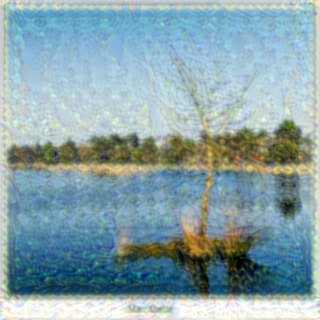

In [12]:
# Note: the model inference can take a few minutes to complete
uploaded_file_path = get_user_test_image()
architecture2_styling(uploaded_file_path)